In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import time
import random
import copy
import math


5个州的分别的总用水需求为 $a_i'$，5个州分别的用电需求为 $b_i'$，可转化为5个州的存水需求 $w_i'$，

假设用水的评价函数为 $score()$，用电的评价函数为 $utility()$，用电到存水的转换函数为 $f()$，则

$$
\begin{aligned}
\max (\frac{\sum_{i=1}^{n} score(x_i)}{n})= & \max(\frac{score(a_1) + score(a_2) + \dots + score(a_5) + utility(b_1) + utility(b_2) + \dots + utility(b_5)}{n}) \\
= & \max(\frac{score(a_1) + score(a_2) + \dots + score(a_5) + score(w_1) + score(w_2) + \dots + score(w_5)}{n}) \\
\therefore utility = f \circ score
\end{aligned}
$$
因此可以直接转化为用水和存水的问题

In [26]:
m=1

M_v = 3000.976144195105 - -940.9125903639906
P_v = 2446.5858645842236 - 197.10793241368083
df_water = pd.read_csv('./water_usage.csv')
A = np.array(eval("""[4632.39
    20171.5
    7849.86
    2203.23
    9412.49]""".replace('\n', ',')))
B = np.array(eval("""[316.5298945
    480.7151231
    147.2743259
    94.57796014
    151.905041]""".replace('\n', ',')))
N = int((M_v*1e4 + P_v*1e4)/3.22321112134556)
bitlength = N.bit_length()
N_GENERATIONS=10000


result for question 2 is 
-------------------------
The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
 238.39224184 362.0471806  110.91861251  71.23071892 114.4062027 ]
The real distribution is  [175.6927 177.1117 131.0719 104.8575 209.7152 209.7216 419.4304 209.7153
 178.6953 104.8575]
The best score is  0.09313839246294477
[0.21017953278534746, 0.04392874089701, 0.11976140661778532, 0.4443423252771447, 0.10147344115827446, -0.000573458686052573, 0.00037788515878539695, 0.0042472501388176554, 0.008442768720100769, -0.0007959674377657324]

result for question 3 is 
-------------------------


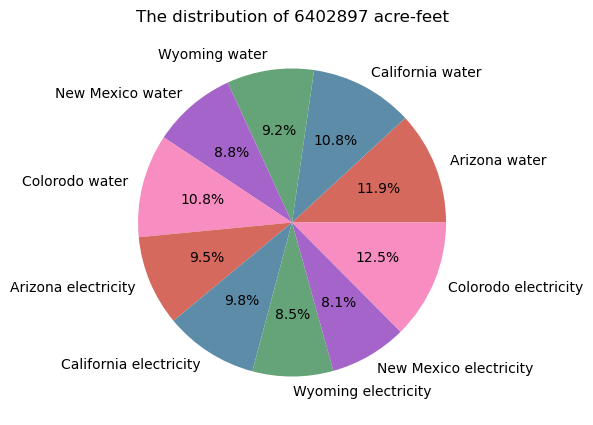

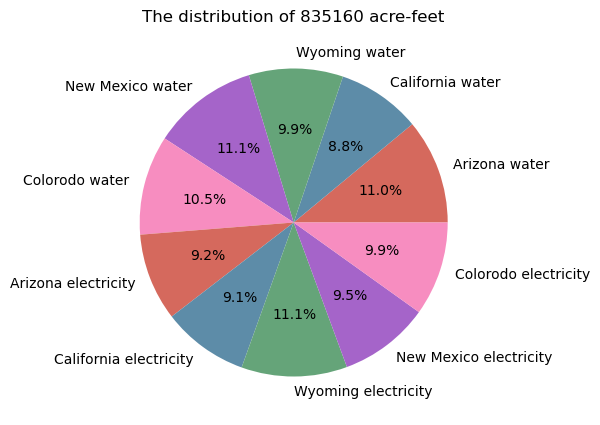

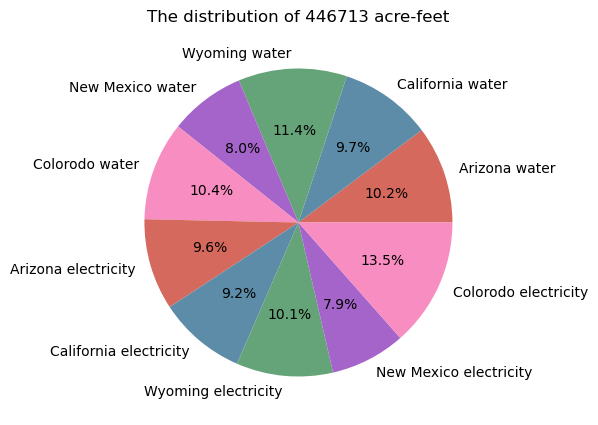

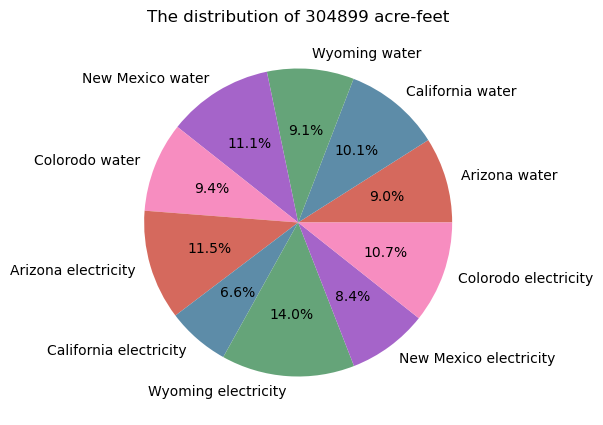

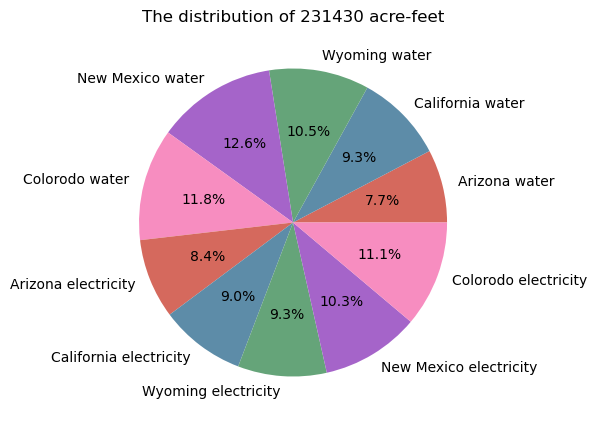

In [27]:
# fitting curve for all: y = 1.1370 lnx + -4.4675
def e2w(y): return np.exp((y + 4.4675) / 1.1370)
def get_a_prime(A, B):
    ratio = B/sum(B)
    return np.append(A, e2w(np.sum(B)) * 1e4 * ratio)

def genetic_algorithm(a_prime, m):
    global N, bitlength, A, B, N_GENERATIONS
    def score(ai, a_primei, m):
        value = m / a_primei - m / ai
        return value

    def evaluate(a, a_prime, m):
        product = 0
        for i in range(len(a)):
            product = product + score(a[i], a_prime[i], m)
        return product / len(a)


    def init_random():
        x, tmp = [], []
        while len(tmp) < 9:
            r = random.randint(0, N)
            if r not in tmp and r != 0 and r != N:
                tmp.append(r)
        tmp.sort()
        x.append(tmp[0])
        for i in range(1, 9):
            x.append(tmp[i]-tmp[i-1])
        x.append(N-tmp[-1])
        return x

    def swap(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        x = list(x)
        np.random.shuffle(x_copy)
        bitlength = N.bit_length()
        s = random.randint(0, bitlength-1)
        new_x[x.index(x_copy[0])] = int((bin(x_copy[0])[2:]).zfill(bitlength)[:s] + bin(x_copy[1])[2:].zfill(bitlength)[s:],2)
        new_x[x.index(x_copy[1])] = int(bin(x_copy[1])[2:].zfill(bitlength)[:s] + bin(x_copy[0])[2:].zfill(bitlength)[s:],2)
        return new_x

    def mutation(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        ridx = random.randint(0, len(x_copy)-1)
        r = random.randint(0, bitlength-1)
        x_copy_bin = (bin(x_copy[ridx])[2:]).zfill(bitlength)
        x_copy_bin = x_copy_bin[:r] + str((int(x_copy_bin[r])+1) % 2) + x_copy_bin[r+1:]
        new_x[ridx] = int(x_copy_bin, 2)
        return new_x

    def legal(x):
        if 0 in x:
            return False
        s = sum(x)
        if s > N:
            return False
        else:
            return True
        
    ## main part
    best_score = -999999
    best = []
    next_x = init_random()
    for _ in range(N_GENERATIONS):
        x = next_x
        y = swap(x)
        if not legal(y):
            y = x
        y_score = evaluate(y, a_prime, m)
        if y_score > best_score:
            best_score = y_score
            best = y
        z = mutation(y)
        if not legal(z):
            z = y
        z_score = evaluate(z, a_prime, m)
        if z_score > best_score:
            best_score = z_score
            best = z
        next_x = best
    best = np.array(best)
    return best, best_score, [score(best[i], a_prime[i], m) for i in range(len(best))]
def main():
    # import 2019 data
    global N, bitlength, A, B, N_GENERATIONS
    A, B = np.array(A), np.array(B)
    A = A / 1e3 * 1e4
    B = B / 365
    a_prime = get_a_prime(A, B)
    best, best_score, score_list = genetic_algorithm(a_prime, m)

    ### print result
    print("result for question 2 is ")
    print("-------------------------")
    print("The demand is ", a_prime/1e4)
    print("The real distribution is ", best/1e4)
    print("The best score is " ,best_score * 1e4)
    print([score_list[i] * 1e4 for i in range(len(best))])

    ### then simulate question C:
    print()
    print("result for question 3 is ")
    print("-------------------------")
    plt.ion()
    N_copy = N
    dividers = np.arange(3, 100, 1) ### 2.01 at question 2
    for idx, divider in enumerate(dividers):
        if (idx % 20 == 0):
            N_copy = N / divider
            best = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            for iter in range(10):
                best_, best_score, score_list = genetic_algorithm(a_prime, m)
                best = best + best_
            best = best / 10
            percentage = best / N_copy * 100
            percentage = [int(i) for i in percentage]
            plt.figure(figsize=(5, 5))
            plt.pie(percentage, colors= ["#d5695d", "#5d8ca8", "#65a479", "#a564c9", "#f78dc0", "#d5695d", "#5d8ca8", "#65a479", "#a564c9", "#f78dc0"], labels = ['Arizona water', 'California water', 'Wyoming water', 'New Mexico water', 'Colorodo water', 'Arizona electricity', 'California electricity', 'Wyoming electricity', 'New Mexico electricity', 'Colorodo electricity'], autopct='%1.1f%%')
            plt.title("The distribution of " + str(int(N_copy)) + " acre-feet")
            plt.show()
    plt.ioff()
main()